# Jupyter Notebook tutorial

_______________
#### introduction

This jupyter notebook will guide you throught the creation of a composite marker.

During this tutorial, we will work with a dataset of images included in the pycopo gitlab repository (https://gitlab.com/symmehub/pycopo.git) 

> **_NOTE:_**  *refer to the usage section to get the pycopo module installation process* 

_______________
#### i_ module importation

>The **first step** consist in importing every module required to run this tutorial:

In [1]:
import os
from PIL import Image
import json
import time
import tarfile

from skimage import io
import numpy as np
from cv2 import aruco
import pycopo as pcp
import matplotlib.pyplot as plt
import networkx as nx

/home/matis/git-clone/pycopo/pycopo/core.py:191: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "cv2":


_______________
#### ii_ image dataset

>Then we need to properly set up our image dataset:

In [2]:
# SETUP
image_directory = "./_dataset/"

metadata = json.load(open(image_directory + "metadata.json"))
camera_matrix = np.array(metadata["camera_matrix"])
distortion_coefficients = np.array(metadata["distortion_coefficients"])
md = float(metadata["aruco_marker_size"].split()[0])
marker_dimension = {i: md for i in range(1, 250)}
marker_size = 12.4079e-3
marker_dimension = {i: marker_size for i in range(1, 250)}

# Aruco settings
parameters = aruco.DetectorParameters()
parameters.cornerRefinementMethod = 1
parameters.cornerRefinementWinSize = 2
parameters.cornerRefinementMaxIterations = 10

In [3]:
target_dir = "../build/html/_images/"
dir = "./_dataset"
files = os.listdir(target_dir)
no_gif = True
for file in files:
    if file.endswith(".gif"):  # Change the file extensions to match your image format
        no_gif = False
if (no_gif):
    images = []
    for file in os.listdir(dir):
        if file.endswith(".tif"):  # Change the file extensions to match your image format
            file_path = os.path.join(dir, file)
            im = Image.open(file_path)
            width, height = im.size
            im = im.resize((int(width/2),int(height/2)))
            images.append(im)
    images[0].save(
        "../build/html/_images/imdataset.gif", save_all=True, append_images=images[1:], duration=500, loop=0
    )

_______________

>Let's have a look on our images:

> **_NOTE:_**  *(here a concatenation of every images from our dataset in a .GIF file)* 


![dataset gif](_images/imdataset.gif)

>A dodecahedron object is set on the center of every images in our dataset. We rotate the object during the photoshoot in order to capture every faces.

>There are as much Aruco markers as the object has faces. **Each of them needs to be identifiable in the dataset** in order to create a composite trackable in every position.

_______________
#### iii_ dataframe initialization

>**Let's create and load a dataframe called batch.**

>This dataframe will contain our images, the corner's coordinates from the markers detected in each image, the poses associated and many more info we are going to manipulate in the creation of our composite. 

In [4]:
# STEP 1: PREPROCESSING
print("# BATCH INTITIALIZATION")
batch = pcp.calibration.ImageBatchCalibration(
    aruco_dict=aruco.DICT_6X6_250,
    parameters=parameters,
    marker_dimension=marker_dimension,
    output_directory="./_outputs_calibration/",
    camera_matrix=camera_matrix,
    distortion_coefficients=distortion_coefficients,
)

batch.load_image_batch(directory=image_directory)

# BATCH INTITIALIZATION


_______________
#### iv_ marker detection et pose estimation

>We initiate the creation of our composite by detecting and estimating the pose of any marker identifiable.

In [5]:
batch.detect_markers(
    plot_markers=False,
    enforce=False,
)
_ = batch.estimate_pose()

Estimating pose on detect id_detect: 1004: 100%|██████████| 1005/1005 [00:13<00:00, 72.86it/s]


>The draw_markers() function allows us to define the contour of an Aruco marker detected in an image and print its id.

>A blue point is also drew at the upper-left corner, allowing us to observe the orientation's marker.

In [6]:
dir = "./_outputs_calibration"
contents = os.listdir(dir)
if len(contents) == 0:
    batch.draw_markers()

>Here a zoomed in image with its marker drew:

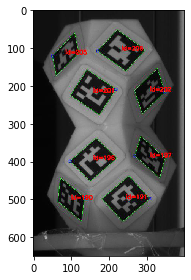

In [7]:
im = io.imread("./_outputs_calibration/img_0099_markers.jpg")
zoomed = im[950:1600, 2400:2800]

io.imshow(zoomed)

_______________
#### v_ graph creation

>If we want to visualize our raw marker/image detection data, we end-up with this graph:

NetworkXError: Node 190 has no position.

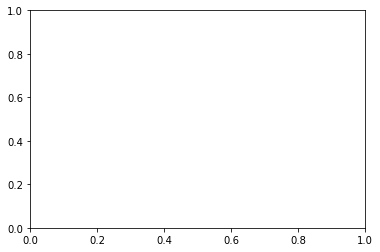

In [9]:
data = batch.merge_all()
MG = pcp.utils.get_multigraph(data=data)
G = pcp.utils.get_graph(data=data)

> *blue nodes: marker poses | red nodes: image*

_______________
#### vi_ GBU algorithm

>**In order to get rid of the pose ambiguity (cf. [pycopo_theory](./pycopo_theory.md)), we submit our dataframe poses info to the GBU algorithm.**

>>The pose filtration process relies on the get_graph_data function from the pycopo module. Here the detailed process:
    
>>* info extraction from our dataframe batch
>>* graph construction based on the image/marker detection info
>>* GBU algorithm filtration
>>* graph updating with the filtered poses
>>* marker counting, checking if we've lost some ids 

In [10]:
batch.get_graph_data(plot_markers=False, criterion=0.15, atomic_cycle=True, deph_max=1)

Working on cycle: ('m189', 'i115', 'm188', 'i114'): 100%|██████████| 680/680 [00:23<00:00, 28.98it/s]


full data 	= 2010 poses
no valid pose 	= 0 poses
out of cycle 	= 328 poses
good data 	= 411 poses
bad data 	= 1157 poses
ambigus data 	= 114 poses


Working on cycle: ('m193', 'i113', 'm204', 'i112'): 100%|██████████| 308/308 [00:09<00:00, 33.89it/s]


full data 	= 525 poses
no valid pose 	= 0 poses
out of cycle 	= 54 poses
good data 	= 378 poses
bad data 	= 48 poses
ambigus data 	= 10 poses
/!\ we lose marker(s) : {192}


index poses detects      rvec                          tvec            \
                                 x         y         z         x         y   
                                                                             
1        1     1       0  1.103566 -0.078667  1.885849 -0.026778 -0.005759   
2        2     2       1  -0.25767 -0.694493  2.356669 -0.006563 -0.005939   
9        9     9       4   0.47126 -0.370985  2.138876 -0.018269 -0.043798   
10      10    10       5 -1.000389 -0.965148   2.25778  0.001085 -0.044721   
17      17    17       8  1.050641 -0.107987  1.917003 -0.026293 -0.005775   
...    ...   ...     ...       ...       ...       ...       ...       ...   
1998  1998  1998     999 -0.244637 -0.531736  0.833634 -0.019624 -0.015908   
2001  2001  2001    1000 -1.004563 -1.319235 -2.295614  0.002927 -0.032986   
2003  2003  2003    1001 -0.431048  0.181347 -2.335636    0.0041 -0.015785   
2006  2006  2006    1003 -0.823899 -0.250302  0.916318  0.018226 -0.025892   
2008  2008  2008    1004  0.369258 -0.761395  0.644886  0.017833 -0.005166   

                    flag  ...          p2d                            \
             z     graph  ...           c0                        c1   
               processed  ...            x            y            x   
1     0.795778      True  ...  2544.101318  1444.704712  2529.856445   
2     0.788194      True  ...  2712.738281  1447.889038  2642.476318   
9     0.789579      True  ...  2627.951416   1158.92749  2579.474854   
10    0.800939      True  ...  2743.412842  1166.369019    2687.8396   
17    0.794175      True  ...  2550.127686  1444.506958  2532.173828   
...        ...       ...  ...          ...          ...          ...   
1998  0.777707      True  ...  2557.278809  1306.167358  2609.578857   
2001  0.799528      True  ...  2729.369873  1268.298584  2664.787354   
2003  0.779741      True  ...  2733.126953  1439.306519   2670.63623   
2006  0.787021      True  ...  2836.290527  1248.925537  2892.291992   
2008  0.785038      True  ...  2840.688965  1399.546387  2889.684082   

                                                                       \
                            c2                        c3                
                y            x            y            x            y   
1     1506.913696  2464.308838  1454.584351  2477.799316  1392.204712   
2     1507.457153  2591.752197  1447.837646  2662.632812  1388.084229   
9     1226.341187  2503.689697  1174.544189  2551.637207  1106.521362   
10    1223.912109  2674.770508  1162.726562  2730.772949  1104.881592   
17    1506.823608  2464.617676   1454.46228  2481.895752  1391.767212   
...           ...          ...          ...          ...          ...   
1998  1377.598877  2549.151855  1438.129639  2496.450439  1366.586548   
2001  1277.742188  2716.446289  1232.045532  2781.067139  1222.459351   
2003  1374.662354  2731.525879  1307.232422   2794.18457  1372.196045   
2006  1320.679932   2838.37085  1349.820557  2781.748047  1277.462158   
2008  1437.755249  2828.743652  1506.837158  2779.269531   1469.53064   

             image                                                     
             fname                                               path  
                                                                       
1     img_0000.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
2     img_0000.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
9     img_0000.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
10    img_0000.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
17    img_0001.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
...            ...                                                ...  
1998  img_0115.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
2001  img_0115.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
2003  img_0115.tif  /home/matis/git-clone/pycopo-doc-web/source/_d...  
2006  img_0115.t

>Once the bad poses cleaned-up, we calibrate our graph in specifying our central markers wich are the graph nodes the most related to the other.

>Here the resulting graph from the whole process:

In [11]:
batch.graph_calibration()

TypeError: plot_graph() missing 1 required positional argument: 'data'

> *green nodes: non-central marker poses | red nodes: image | blue nodes: central marker poses*

In [12]:
batch.optimize_calibration()

(<Pycopo Composite Marker w. 20 markers>,
 <Pycopo Pose batch w. 90 entries>,
  active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

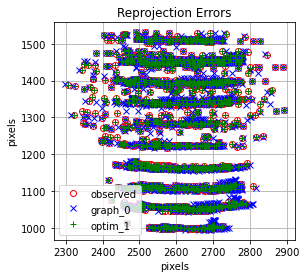

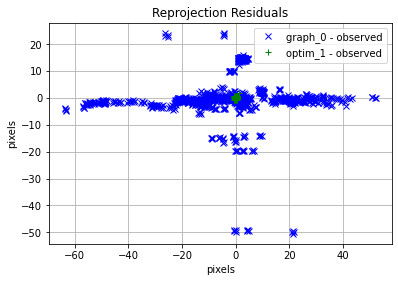

KeyError: 'img_0000.tif'

In [21]:
batch.plot_reprojection_errors()

In [22]:
batch.save_composite()

AttributeError: 'ImageBatchCalibration' object has no attribute 'save_composite'